# Computers, Waves, Simulations
## Spectral Element Method - Heterogeneous Elastic Wave Equation 1D 

## Basic Equations

The numerical description of 1D-elastic waves propagating in a heterogeneous media is a natural extension of the homogeneous case. From an algorithmic point of view, now we allow both mass, and stiffness matrices to be initialized separately for each element. In contrast with the homogeneous case, elastic parameters $\lambda$ and $\mu$ may vary at each collocation point. 

From a theoretical point of view, we basically follow the same strategy developed in the homogeneous case. The numerical solution for the 1D elastic wave equation

\begin{equation}
\rho(x) \partial_t^2 u(x,t) = \partial_x (\mu(x) \partial_x u(x,t)) + f(x,t),
\end{equation}

using the spectral element method is done after a series of steps summarized as follow:

1) The wave equation is written into its weak form

2) Assume stress-free boundary condition after integration by parts 

3) Approximate the wave field as a linear combination of some basis

\begin{equation}
u(x,t) \ \approx \ \overline{u}(x,t) \ = \ \sum_{i=1}^{n} u_i(t) \ \varphi_i(x)
\end{equation}

4) Use the same basis functions in $u(x, t)$ as test functions in the weak form, the so call Galerkin principle.

6) The continuous weak form is written as a system of linear equations by considering the approximated displacement field.

\begin{equation}
\mathbf{M}^T\partial_t^2 \mathbf{u} + \mathbf{K}^T\mathbf{u} = \mathbf{f}
\end{equation}

7) Time extrapolation with centered finite differences scheme

\begin{equation}
\mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt).
\end{equation}

where $\mathbf{M}$ is known as the mass matrix, and $\mathbf{K}$ the stiffness matrix.

The above solution is exactly the same presented for the classic finite-element method. Now we introduce appropriated basis functions and integration scheme to efficiently solve the system of matrices.

#### Interpolation with Lagrange Polynomials
At the elemental level (see section 7.4), we introduce as interpolating functions the Lagrange polynomials and use $\xi$ as the space variable representing our elemental domain:

\begin{equation}
\varphi_i \ \rightarrow \ \ell_i^{(N)} (\xi) \ := \ \prod_{j \neq i}^{N+1} \frac{\xi - \xi_j}{\xi_i-\xi_j}, \qquad   i,j = 1, 2, \dotsc , N + 1  
\end{equation}

#### Numerical Integration
The integral of a continuous function $f(x)$ can be calculated after replacing $f(x)$ by a polynomial approximation that can be integrated analytically. As interpolating functions we use again the Lagrange polynomials and
obtain Gauss-Lobatto-Legendre quadrature. Here, the GLL points are used to perform the integral. 

\begin{equation}
\int_{-1}^1 f(x) \ dx \approx \int _{-1}^1 P_N(x) dx = \sum_{i=1}^{N+1}
 w_i f(x_i) 
\end{equation}



In [1]:
import numpy as np
import matplotlib

matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from gll import gll
from lagrange1st import lagrange1st
from ricker import ricker

### 1. Initialization of setup

In [2]:
# Initialization of setup
nt = 7500  # number of time steps
xmax = 8000  # length of domain (m)
N = 3  # order of Lagrange polynomials
ne = 150  # number of elements
Tdom = 0.4  # dominant period of Ricker source wavelet
iplot = 30  # plot snapshot frequency
vs = 2500  # S velocity (m/s)
rho = 2000  # density (kg/m^3)

# variables for elemental matrices
Me = np.zeros(N + 1, dtype=float)
Ke = np.zeros((N + 1, N + 1), dtype=float)

# Initialization of GLL points integration weights
[xi, w] = gll(N)  # xi, N+1 coordinates [-1, 1] of GLL points
# w integration weights at GLL locations

# space domain
le = xmax / ne  # length of elements
# vector with GLL points
k = 0
xg = np.zeros((N * ne) + 1)
xg[k] = 0
for i in range(1, ne + 1):
    for j in range(N):
        k = k + 1
        xg[k] = (i - 1) * le + 0.5 * (xi[j + 1] + 1) * le

dxmin = min(np.diff(xg))
eps = 0.1  # stability criteria
dt = eps * dxmin / vs  # global time step

# mapping - Jacobian
J = le / 2
Ji = 1 / J

# 1st derivative of Lagrange polynomials
l1d = lagrange1st(N)  # Array with GLL as columns for each N+1 polynomial

### 2. Low velocity zone
The introduction of an specific velocity model is done after allowing space-dependent elastic parameters. i.e. 

\begin{equation}
\mu(x) = \rho(x) v_s(x)
\end{equation}

The following python code introduces a low-velocity zone (-40%) at the center of the model spanning 50 elements and visualizes the model. There is the possibility to try different velocity and density models by defining new python methods.

In [3]:
# Elastic parameters, low velocity zone (40%)
el_span = 25  # number of elements spanning low velocity zone
percent = 40  # percent of max velocity
a = el_span * N + 1  # width of the fault zone in grid points
b = int(np.floor((N * ne + 1) / 2))  # half of the space domain

vs = vs * np.ones((N * ne + 1))
rho = rho * np.ones((N * ne + 1))

vs[b - int(a / 2) : b + int(a / 2)] = max(vs) * percent / 100
mu = rho * vs**2  # shear modulus

<IPython.core.display.Javascript object>


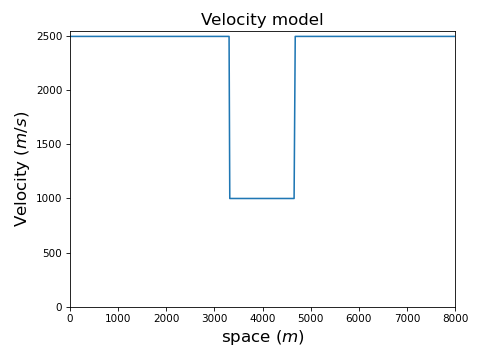

In [4]:
# Plot velocity model, Low velocity zone(-40%)
plt.plot(xg, vs, lw=1.5)
plt.title("Velocity model", fontsize=16)
plt.ylabel("Velocity $(m/s)$", fontsize=16)
plt.xlabel("space $(m)$", fontsize=16)
plt.xlim((0, xmax))
plt.ylim((0, max(vs) + 50))
plt.tight_layout()
plt.show()

### 3. The Mass Matrix
Now we initialize the mass and stiffness matrices. In general, the mass matrix at the elemental level is given

\begin{equation}
M_{ji}^e \ = \ w_j  \ \rho (\xi)  \ \frac{\mathrm{d}x}{\mathrm{d}\xi} \delta_{ij} \vert_ {\xi = \xi_j}
\end{equation}

 
We implement the mass matrix at each element using the integration weights at GLL locations $w$, the Jacobian $J$, and density $\rho$. Then, perform the global assembly of the mass matrix, compute its inverse, and display the inverse mass matrix to visually inspect how it looks like.

<IPython.core.display.Javascript object>


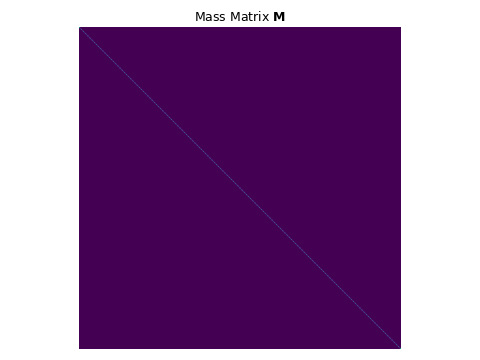

In [5]:
# Global mass matrix
k = -1
m = -1
ng = (ne - 1) * N + N + 1
M = np.zeros(2 * ng)
for i in range(1, ne + 1):
    # Elemental mass matrix
    for l in range(N + 1):
        m += 1
        Me[l] = rho[m] * w[l] * J  # stored as a vector since it's diagonal
    m -= 1
    for j in range(N + 1):
        k += 1
        if i > 1 and j == 0:
            k -= 1
        M[k] = M[k] + Me[j]


# inverse of M
Minv = np.identity(ng)
for i in range(ng):
    Minv[i, i] = 1 / M[i]

# Display inverse mass matrix inv(M)
plt.figure()
plt.imshow(Minv)
plt.title("Mass Matrix $\mathbf{M}$")
plt.axis("off")
plt.tight_layout()
plt.show()

### 4. The Stiffness matrix
On the other hand, the general form of the stiffness matrix at the elemental level is

\begin{equation}
K_{ji}^e \ = \ \sum_{k = 1}^{N+1} w_k \mu (\xi) \partial_\xi \ell_j (\xi) \partial_\xi \ell_i (\xi) \left(\frac{\mathrm{d}\xi}{\mathrm{d}x} \right)^2 \frac{\mathrm{d}x}{\mathrm{d}\xi} \vert_{\xi = \xi_k}
\end{equation} 

Implementing, now, for the stiffness matrix at each element using the integration weights at GLL locations $w$, the Jacobian $J$, and shear stress $\mu$. Then, perform the global assembly of the mass matrix and display the matrix.

<IPython.core.display.Javascript object>


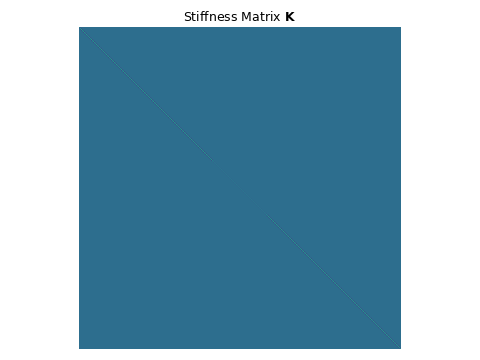

In [6]:
# Global stiffness matrix
K = np.zeros([ng, ng])
xe = 0

for e in range(1, ne + 1):
    i0 = (e - 1) * N + 1
    j0 = i0
    # elemental stiffness matrix
    for i in range(-1, N):
        for j in range(-1, N):
            s = 0  # sum
            for k in range(-1, N):
                s += (
                    mu[k + 1 + xe]
                    * w[k + 1]
                    * Ji**2
                    * J
                    * l1d[i + 1, k + 1]
                    * l1d[j + 1, k + 1]
                )
            Ke[i + 1, j + 1] = s
    xe += N

    for i in range(-1, N):
        for j in range(-1, N):
            K[i0 + i, j0 + j] += Ke[i + 1, j + 1]


# Display stiffness matrix K
plt.figure()
plt.imshow(K)
plt.title("Stiffness Matrix $\mathbf{K}$")
plt.axis("off")

plt.tight_layout()
plt.show()

### 5. Finite element solution 

Finally we implement the spectral element solution using the computed mass $M$ and stiffness $K$ matrices together with a finite differences extrapolation scheme

\begin{equation}
\mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt).
\end{equation}

<IPython.core.display.Javascript object>


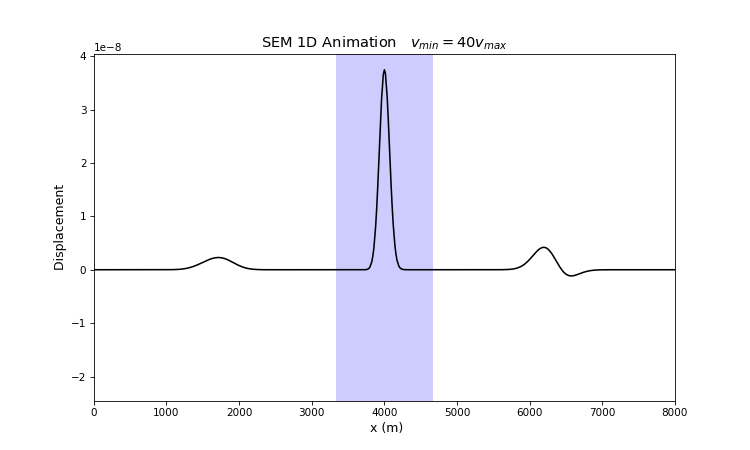

In [7]:
# SE solution, time extrapolation

# initialize source time function and force vector f
src = ricker(dt, Tdom)
isrc = int(np.floor(ng / 2))  # source location

# initialization of solution vectors
u = np.zeros(ng)
uold = u.copy()
unew = u.copy()
f = u.copy()

# Initialize animated plot
plt.figure(figsize=(10, 6))
# plt.figure(figsize=(18,10))

# ploting low velocity zone
half = np.floor(xmax / 2)
plt.axvspan(half - el_span / 2 * le, half + el_span / 2 * le, alpha=0.2, facecolor="b")
plt.title("SEM 1D Animation")
plt.xlabel(" x (m)")
plt.ylabel(" Amplitude ")
font = {
    "family": "serif",
    "color": "black",
    "weight": "normal",
    "size": 14,
}

lines = plt.plot(xg, u, lw=1.5)
plt.title("SEM 1D Animation   $v_{min} = %s v_{max}$" % percent, size=14)
plt.xlabel(" x (m)", size=12)
plt.ylabel(" Displacement ", size=12)

plt.ion()  # set interective mode
plt.show()


# time extrapolation
x_t = []
for it in range(nt):
    # source initialization
    f = np.zeros(ng)
    if it < len(src):
        f[isrc - 1] = src[it - 1]

    # time extrapolation
    unew = dt**2 * Minv @ (f - K @ u) + 2 * u - uold
    uold, u = u, unew

    # solution in space-time
    x_t.append(u)

    # Animation plot. Display solution
    if not it % iplot:
        for l in lines:
            l.remove()
            del l
        # --------------------------------------
        # Display lines
        lines = plt.plot(xg, u, color="black", lw=1.5)
        plt.xlim((0, xmax))

        plt.gcf().canvas.draw()